# Análisis de los datos

In [30]:
# importar librerias necesarias
import pandas as pd # para manejar dataframes
import matplotlib.pyplot as plt
import numpy as np

In [19]:
df_data = pd.read_csv('../csvFiles/raw_pacientes.csv', dtype=object)

In [20]:
df_data.head()

,SubjectID,DateID,GestureLabel,RepetitionNumber,CorrectLabel,Position,JointName,TrackedStatus,3D_X,3D_Y,3D_Z,2D_X,2D_Y
0,101,18,0,1,1,stand,SpineBase,Tracked,-0.1028086,0.06965441,2.464606,243.133,196.5854
1,101,18,0,1,1,stand,SpineMid,Tracked,-0.1026228,0.3837799,2.438919,242.971,149.1077
2,101,18,0,1,1,stand,Neck,Tracked,-0.1025293,0.6877351,2.40196,242.6967,101.3569
3,101,18,0,1,1,stand,Head,Tracked,-0.1190992,0.8358598,2.373549,239.9086,76.90204
4,101,18,0,1,1,stand,ShoulderLeft,Tracked,-0.2826451,0.5525576,2.38421,214.7496,121.544


## 1. Posición a través de t

Posición de la muñeca de una persona sana (102) vs un paciente (id: 206) realizando una flexión de hombro

In [21]:
def repetition_graph(df:pd.DataFrame):
    groups = df.groupby("RepetitionNumber")
 
    for name, group in groups:
        spinBase = group[group['JointName']=='SpineBase']['3D_X']
        WristRight = group[group['JointName']=='WristRight']['3D_X']
        normalize_gesture = WristRight.values - spinBase.values
        plt.plot(normalize_gesture, label = "repetition "+ str(name))
        plt.legend()


In [22]:
def extraer_persona(df:pd.DataFrame, id:str, id_gesture:str):
    conditions = (df['SubjectID'] == id) & (df['GestureLabel'] == id_gesture)  & (df['Position'] =='stand')
    persona = df[conditions]
    persona = persona.apply(lambda x: pd.to_numeric(x, errors = 'ignore'))
    return persona

In [23]:
persona_sana = extraer_persona(df_data, '102', '2')
paciente_206 = extraer_persona(df_data, '206', '2')

C:\Users\nerea\AppData\Local\Temp\ipykernel_7708\1154384310.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  persona = persona.apply(lambda x: pd.to_numeric(x, errors = 'ignore'))


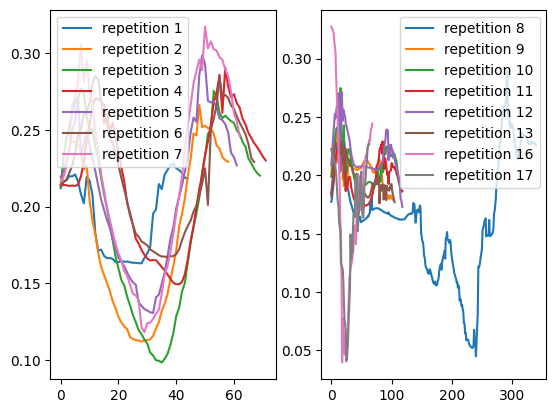

In [25]:
fig = plt.figure()
plt.subplot(1, 2, 1)
repetition_graph(persona_sana)

plt.subplot(1, 2, 2)
repetition_graph(paciente_206)

plt.show()

## 2. Numero de correctas e incorrectas

## 3. Calcular los ángulos

<div>
<img src="../images/gestures.png" width="500"/>
</div>

In [28]:
# nueva función para calcular el angulo
# a, b y c son los key points
def calculate_angle(a,b,c):
    # convierte las varaiables en np.array para que sean más faciles de manejar
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    # cacular los radianes y el angulo
    # los [13] representan las y y los [12] las x
    radians = np.arctan2(c[13]-b[13], c[12]-b[12]) - np.arctan2(a[13]-b[13], a[12]-b[12])
    angle = np.abs(radians*180.0/np.pi)
    
    # para tener un maximo de 180 grados
    if angle > 180.0:
        angle = 360-angle
        
    return angle 

Key point necesarios para calccular el ángulo de cada movimiento

In [36]:
columnas = ['SubjectID', 'GestureLabel', 'RepetitionNumber', 'CorrectLabel']



# agrupar por frames (24 filas)
for keyPoint in df_data.rolling(window=25):
    print(keyPoint)


  SubjectID DateID GestureLabel RepetitionNumber CorrectLabel Position  \
0       101     18            0                1            1    stand   

   JointName TrackedStatus        3D_X        3D_Y      3D_Z     2D_X  \
0  SpineBase       Tracked  -0.1028086  0.06965441  2.464606  243.133   

       2D_Y  
0  196.5854  
  SubjectID DateID GestureLabel RepetitionNumber CorrectLabel Position  \
0       101     18            0                1            1    stand   
1       101     18            0                1            1    stand   

   JointName TrackedStatus        3D_X        3D_Y      3D_Z     2D_X  \
0  SpineBase       Tracked  -0.1028086  0.06965441  2.464606  243.133   
1   SpineMid       Tracked  -0.1026228   0.3837799  2.438919  242.971   

       2D_Y  
0  196.5854  
1  149.1077  
  SubjectID DateID GestureLabel RepetitionNumber CorrectLabel Position  \
0       101     18            0                1            1    stand   
1       101     18            0            

KeyboardInterrupt: 